### Problem Statement 

Schuster is a multinational retail company dealing in sports goods and accessories. Schuster conducts significant business with hundreds of its vendors, with whom it has credit arrangements. Unfortunately, not all vendors respect credit terms and some of them tend to make payments late. Schuster levies heavy late payment fees, although this procedure is not beneficial to either party in a long-term business relationship. The company has some employees who keep chasing vendors to get the payment on time; this procedure nevertheless also results in non-value-added activities, loss of time and financial impact. Schuster would thus try to understand its customers’ payment behaviour and predict the likelihood of late payments against open invoices.

To understand how to approach this problem using data science, let’s first understand the payment process at Schuster now. Every time a transaction of goods takes place with a vendor, the accounting team raises an invoice and shares it with the vendor. This invoice contains the details of the goods, the invoice value, the creation date and the payment due date based on the credit terms as per the contract. Business with these vendors occurs quite frequently. Hence, there are always multiple invoices associated with each vendor at any given time.

### Goal 

1) Schuster would like to better understand the customers’ payment behaviour based on their past payment patterns (customer segmentation). 
2) Using historical information, it wants to be able to predict the likelihood of delayed payment against open invoices from its customers. 
3) It wants to use this information so that collectors can prioritise their work in following up with customers beforehand to get the payments on time.

### Importing Libraries & Dataset

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reading & Understanding The Data

In [2]:
df_payment=pd.read_csv('Received_Payments_Data.csv')
df_payment.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [3]:
Data_Dict = pd.read_excel('Data+Dictionary.xlsx', header=None)

In [4]:
# Understanding the columns with the help of Data Dictionary
for i in range(16):
    print(Data_Dict[0][i], ':', Data_Dict[1][i])

RECEIPT_METHOD : In which method payments have been made
CUSTOMER_NAME : Name of the customer/vendor
CUSTOMER_NUMBER : Customer's unique identity number
RECEIPT_DOC_NO : Reference number of the payment receipt
RECEIPT_DATE : The date in which the payment has been made
CLASS : As the payment against these invoices have already been received so Transaction Class as PMT (short for Payment) assigned
CURRENCY_CODE : Currency used for the payment
Local Amount : Invoice value in local currency
USD Amount : Invoice Value converted to USD
INVOICE_ALLOCATED : Invoice number that has been allocated to a particular vendor
INVOICE_CREATION_DATE : The date on which the invoice was created
DUE_DATE : The date by which the payment was to be made
PAYMENT_TERM : Days given to the vendor/customer for making the payments
INVOICE_CLASS : Three types of Invoice classes - Credit Memo or Credit Note (CM), Debit Memo or Debit Note (DM) or Invoice (INV)
INVOICE_CURRENCY_CODE : Currency code as per the invoice g

In [5]:
df_payment.shape

(93937, 16)

In [6]:
df_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [7]:
df_payment.RECEIPT_METHOD.value_counts(normalize=True)

WIRE             0.898549
AP/AR Netting    0.051598
CHEQUE           0.036961
CASH             0.008325
I/C WIRE         0.002246
PDC              0.002236
I/C Check        0.000064
I/C CASH         0.000021
Name: RECEIPT_METHOD, dtype: float64

The 'RECEIPT_DOC_NO' has missing values of 0.003% null values. Would Drop this column as this is not useful for Model Building

In [8]:
df_payment.describe()

,CUSTOMER_NUMBER,RECEIPT_DOC_NO,Local Amount,USD Amount
count,93937.000000,9.390800e+04,9.393700e+04,9.393700e+04
mean,12753.874033,1.583908e+11,1.066470e+06,5.312013e+05
std,14274.170829,3.885359e+10,1.546901e+06,9.508693e+05
min,1044.000000,1.421000e+10,0.000000e+00,0.000000e+00
25%,1888.000000,1.470000e+11,8.198039e+04,3.766298e+04
50%,4003.000000,1.510000e+11,4.053438e+05,1.810010e+05
75%,20884.000000,1.690000e+11,1.425606e+06,5.996137e+05
max,52940.000000,2.970000e+11,1.084983e+07,1.084983e+07


In [9]:
df_payment.nunique()

RECEIPT_METHOD               8
CUSTOMER_NAME              690
CUSTOMER_NUMBER           1054
RECEIPT_DOC_NO              73
RECEIPT_DATE               170
CLASS                        1
CURRENCY_CODE                8
Local Amount              7752
USD Amount                7820
INVOICE_ALLOCATED        12986
INVOICE_CREATION_DATE     1310
DUE_DATE                  1203
PAYMENT_TERM                42
INVOICE_CLASS                3
INVOICE_CURRENCY_CODE       10
INVOICE_TYPE                 2
dtype: int64

In [10]:
df_payment.INVOICE_TYPE.value_counts(normalize=True)

Goods        0.71021
Non Goods    0.28979
Name: INVOICE_TYPE, dtype: float64

### Handling Missing Values

In [11]:
round(df_payment.isnull().sum()/len(df_payment),4)

RECEIPT_METHOD           0.0000
CUSTOMER_NAME            0.0000
CUSTOMER_NUMBER          0.0000
RECEIPT_DOC_NO           0.0003
RECEIPT_DATE             0.0000
CLASS                    0.0000
CURRENCY_CODE            0.0000
Local Amount             0.0000
USD Amount               0.0000
INVOICE_ALLOCATED        0.0000
INVOICE_CREATION_DATE    0.0000
DUE_DATE                 0.0000
PAYMENT_TERM             0.0000
INVOICE_CLASS            0.0000
INVOICE_CURRENCY_CODE    0.0000
INVOICE_TYPE             0.0000
dtype: float64

#### Columns Related To Date Lets Converted To Date Type

In [12]:
df_payment['DUE_DATE']=pd.to_datetime(df_payment['DUE_DATE'])
df_payment['RECEIPT_DATE']=pd.to_datetime(df_payment['RECEIPT_DATE'])
df_payment['INVOICE_CREATION_DATE']=pd.to_datetime(df_payment['INVOICE_CREATION_DATE'])

#### Creating a New Calculated Column for Target Variable and Payment Term Days

1) Payment Status:

Description: Indicates whether a payment was late or on time.
Calculation: Payment Status = (RECEIPT_DATE - DUE_DATE)
Values:
Late Payment: 1
On Time Payment: 0

2) Payment Term Days:

Description: The number of days between the invoice creation date and the due date.
Calculation: Payment Term Days = (DUE_DATE - INVOICE_CREATION_DATE)

In [13]:
df_payment['late_days']=(df_payment['RECEIPT_DATE']-df_payment['DUE_DATE']).apply(lambda x:x.days)
df_payment['payment_term_days']=df_payment['DUE_DATE']-df_payment['INVOICE_CREATION_DATE']
df_payment['Target_Variable']=df_payment['late_days'] > 0
df_payment['payment_term_days']=df_payment['payment_term_days'].apply(lambda x:x.days)

In [14]:
df_payment['Target_Variable'].value_counts()

True     61978
False    31959
Name: Target_Variable, dtype: int64

In [15]:
df_payment['Target_Variable'].value_counts(normalize=True)

True     0.659783
False    0.340217
Name: Target_Variable, dtype: float64

In [16]:
df_payment.head(10)

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,late_days,payment_term_days,Target_Variable
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,111,58,True
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,3,30,True
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,-29,30,False
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,30,True
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,30,True
5,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000040,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,30,True
6,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,3,30,True
7,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,-29,30,False
8,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,30,True
9,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,-29,30,False


In [17]:
# Check if the USD amount is less than zero
df_payment['USD Amount'].min()

0.0

In [18]:
# Check for invoice classification
df_payment['INVOICE_CLASS'].value_counts()

INV    88124
CM      5261
DM       552
Name: INVOICE_CLASS, dtype: int64

A Credit Note or Credit Memo is a document used in sales transactions when the seller owes either a refund or credit previously billed.
In our dataset, entries classified as "CM" (Credit Memo) in the Invoice Class should be deleted, as these represent payments to be made by Schuster.

To ensure data accuracy and relevance, follow these steps:

1) Identify all entries with the Invoice Class labeled as "CM."

2) Remove these entries from the dataset, as they indicate payments from Schuster and are not relevant to the analysis of sales transactions.

By removing these Credit Memo entries, we focus solely on the actual sales transactions, ensuring a more accurate analysis of the payment behavior and terms.

In [19]:
df_payment=df_payment[df_payment['INVOICE_CLASS'] !='CM']

In [20]:
df_payment.payment_term_days.min()

-3622

In [21]:
df_payment=df_payment[df_payment['payment_term_days']>=0]
df_payment.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,late_days,payment_term_days,Target_Variable
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,111,58,True
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,3,30,True
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,-29,30,False
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,30,True
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,30,True


In [22]:
df_payment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85915 entries, 0 to 93936
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         85915 non-null  object        
 1   CUSTOMER_NAME          85915 non-null  object        
 2   CUSTOMER_NUMBER        85915 non-null  int64         
 3   RECEIPT_DOC_NO         85899 non-null  float64       
 4   RECEIPT_DATE           85915 non-null  datetime64[ns]
 5   CLASS                  85915 non-null  object        
 6   CURRENCY_CODE          85915 non-null  object        
 7   Local Amount           85915 non-null  float64       
 8   USD Amount             85915 non-null  float64       
 9   INVOICE_ALLOCATED      85915 non-null  object        
 10  INVOICE_CREATION_DATE  85915 non-null  datetime64[ns]
 11  DUE_DATE               85915 non-null  datetime64[ns]
 12  PAYMENT_TERM           85915 non-null  object        
 13  I

#### Lets Begin With Exploratory Data Analysis - How can we analyse the customer transactions data to find different payment behaviours?

In [23]:
# Lets check the customer segmentation
cat_cols=['RECEIPT_METHOD','CLASS','CURRENCY_CODE','INVOICE_CLASS','INVOICE_CURRENCY_CODE','INVOICE_TYPE']
num_cols=['Local Amount','USD Amount','late_days','payment_term_days']

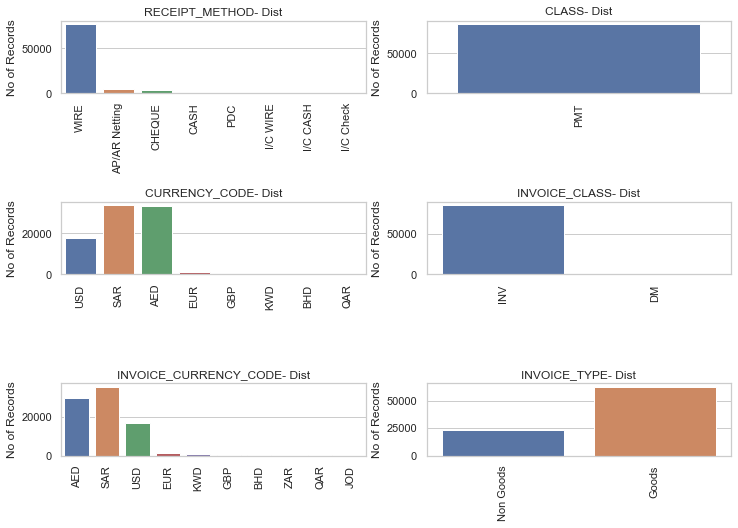

In [24]:
#Visualizing the distribution of the categorical variables

plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
for i in range(len(cat_cols)):
    plt.subplot(3, 2,  i+1)
    cat=cat_cols[i]
    sns.countplot(x=cat, data=df_payment)
    plt.title(cat+'- Dist')
    plt.ylabel ('No of Records')
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.subplots_adjust(hspace=1.5)

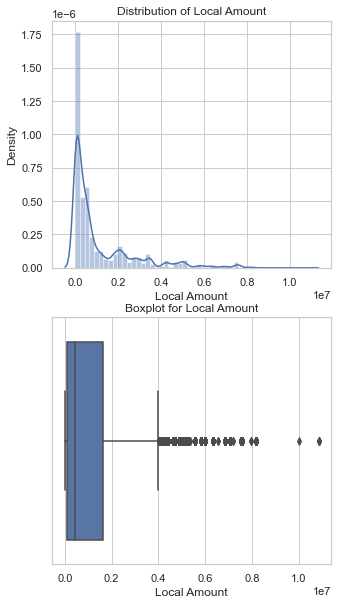

In [25]:
# Visualizing the distribution of Local Amount
plt.figure(figsize= (5,10))
plt.subplot(2,1,1)
sns.distplot(df_payment['Local Amount'])
plt.title('Distribution of Local Amount')
plt.subplot(2,1,2)
sns.boxplot(df_payment['Local Amount'])
plt.title('Boxplot for Local Amount')
plt.show()

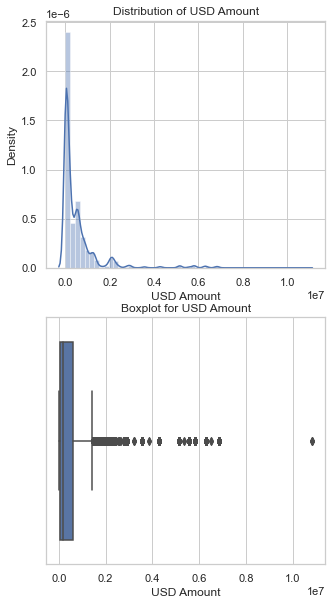

In [26]:
# Visualizing the distribution of USD Amount
plt.figure(figsize= (5,10))
plt.subplot(2,1,1)
sns.distplot(df_payment['USD Amount'])
plt.title('Distribution of USD Amount')
plt.subplot(2,1,2)
sns.boxplot(df_payment['USD Amount'])
plt.title('Boxplot for USD Amount')
plt.show()

<Figure size 576x576 with 0 Axes>

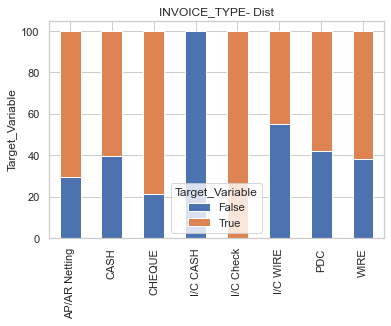

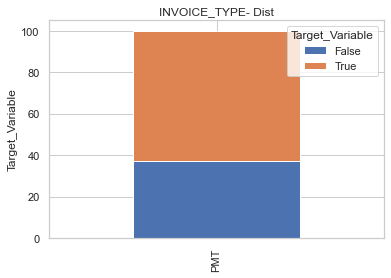

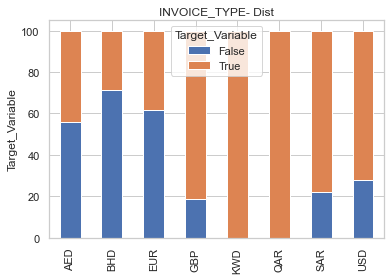

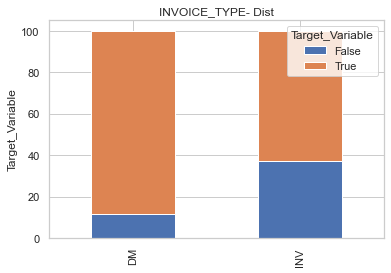

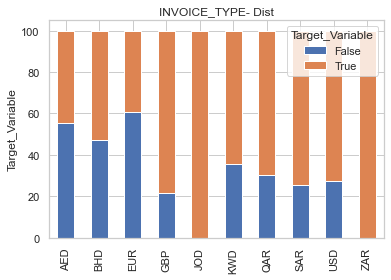

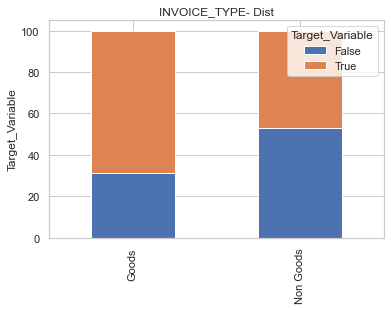

In [27]:
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
for i in cat_cols:
    pivot_df=df_payment.pivot_table(index=i, columns='Target_Variable', aggfunc='size', fill_value=0)
    pivot_df_percent=pivot_df.div(pivot_df.sum(axis=1), axis=0)*100
    
    pivot_df_percent.plot(kind='bar', stacked=True)
    plt.title(cat+'- Dist')
    plt.ylabel ('Target_Variable')
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.show()

In [28]:
# Check the numerical col with target variable in this case Payment_status
def nums_col(Target_Variable,cols):
    plt.figure(figsize=(4,4))
    ax=sns.boxplot(x=Target_Variable, y=cols, data=df_payment)
    plt.show()

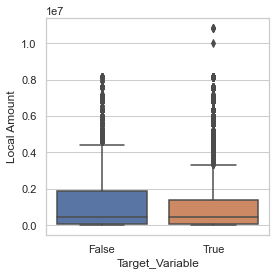

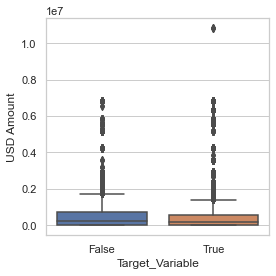

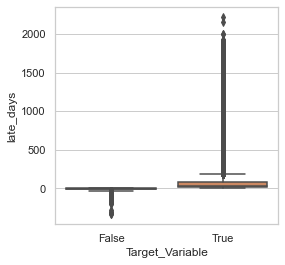

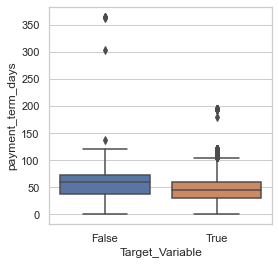

In [29]:
for c in num_cols:
    nums_col('Target_Variable',c)

In [30]:
# Lets remove the outliers present in the numerical columns and then again check the boxplot.

for i in num_cols:
    df_payment=df_payment[df_payment[i]<=np.percentile(df_payment[i],99)]

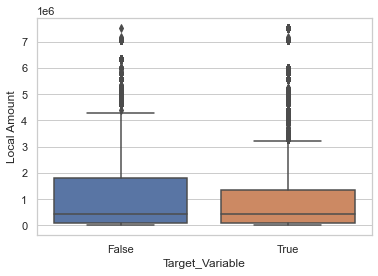

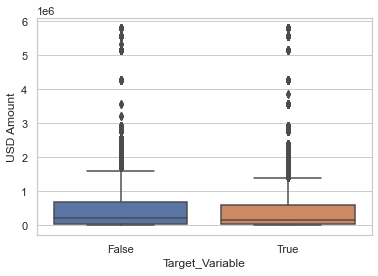

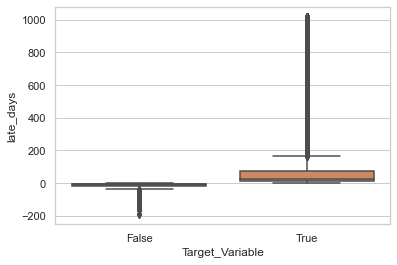

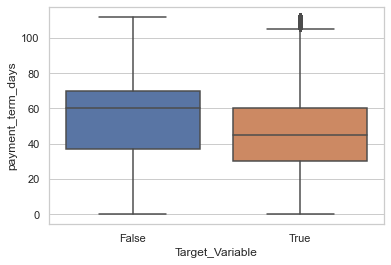

In [31]:
for i in num_cols:
    sns.boxplot(data=df_payment, y=i, x='Target_Variable')
    plt.show()

#### Customer Segmentation Based on Behavior - In which way can you segregate the customers based on their previous payment patterns/behaviours?

In [32]:
df_clustering=df_payment[['CUSTOMER_NUMBER','late_days','payment_term_days','Target_Variable']]

In [33]:
df_clustering['Avg_late_payment']=df_clustering.groupby('CUSTOMER_NUMBER')['late_days'].transform('mean')
df_clustering['Std_late_payment']=df_clustering.groupby('CUSTOMER_NUMBER')['late_days'].transform('std')

In [34]:
df_clustering

,CUSTOMER_NUMBER,late_days,payment_term_days,Target_Variable,Avg_late_payment,Std_late_payment
0,37403,111,58,True,52.000000,61.098281
1,4003,3,30,True,5.837174,23.786510
2,4003,-29,30,False,5.837174,23.786510
3,1409,17,30,True,100.176536,247.281135
4,4003,17,30,True,5.837174,23.786510
...,...,...,...,...,...,...
93928,21144,-4,57,False,1.933333,19.001754
93929,21144,20,60,True,1.933333,19.001754
93931,21144,47,54,True,1.933333,19.001754
93935,21145,8,59,True,16.939189,27.917085


In [35]:
df_clustering2=df_clustering[['CUSTOMER_NUMBER','Avg_late_payment','Std_late_payment']]

In [36]:
df_clustering3=df_clustering2.drop_duplicates()

In [37]:
df_clustering3.isnull().sum()

CUSTOMER_NUMBER       0
Avg_late_payment      0
Std_late_payment    162
dtype: int64

Handling Null Values after Grouping by Standard Deviation:
During the process of grouping by standard deviation, certain rows may end up with null values, especially if there is only one entry related to a particular customer. To ensure data integrity and avoid potential issues in subsequent analysis, it is prudent to remove these rows.

In [38]:
df_clustering3=df_clustering3.dropna()

<AxesSubplot:xlabel='Avg_late_payment'>

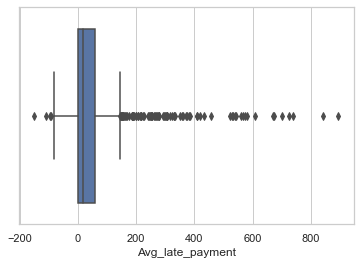

In [39]:
sns.boxplot(df_clustering3.Avg_late_payment)

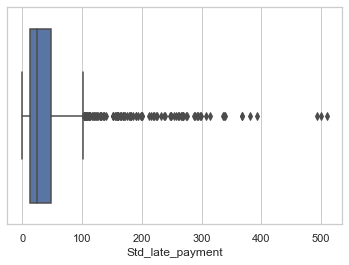

In [40]:
sns.boxplot(df_clustering3.Std_late_payment)
plt.show()

In [41]:
# Rescaling of the data to standardize
from sklearn.preprocessing import StandardScaler
SS_df=df_clustering3[['Std_late_payment','Avg_late_payment']]

# Instantiate the StandardScaler
scaler= StandardScaler()

# Fit Transform on the data
SS_df_scaled = scaler.fit_transform(SS_df)
SS_df_scaled.shape

(867, 2)

In [42]:
SS_df_scaled=pd.DataFrame(SS_df_scaled)

In [43]:
SS_df_scaled.columns = ['Std_late_payment', 'Avg_late_payment']

In [44]:
SS_df_scaled.describe()

,Std_late_payment,Avg_late_payment
count,8.670000e+02,8.670000e+02
mean,-1.701830e-16,2.228129e-17
std,1.000577e+00,1.000577e+00
min,-6.921904e-01,-1.770878e+00
25%,-5.163505e-01,-4.642861e-01
50%,-3.448166e-01,-2.938109e-01
75%,4.253326e-03,4.527023e-02
max,6.726079e+00,7.359086e+00


### K Means Clustering

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [46]:
kmeans = KMeans(n_clusters = 4, max_iter = 50)
kmeans.fit(SS_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [47]:
kmeans.labels_

array([1, 1, 3, 0, 0, 1, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 0, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 3, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 3, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3,

In [48]:
temp = pd.Series(kmeans.labels_)

In [49]:
temp.value_counts()

1    687
0    116
3     43
2     21
dtype: int64

### ELBOW CURVE

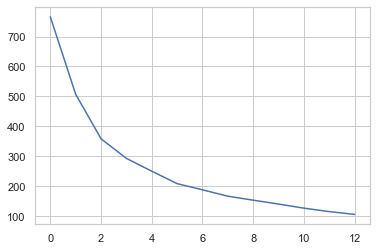

In [50]:
ssd = []
range_n_clusters = range(2,15)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(SS_df_scaled)
    
    ssd.append(kmeans.inertia_)

# plot the SSD's for each n_clusters
# ssd

plt.plot(ssd)

### Silhouette Analysis

In [51]:
range_n_clusters = range(2, 15)

for num_clusters in range_n_clusters:
    # to Initialize KMeans
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(SS_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # To Calculate the Silhouette Score
    
    silhouette_avg =  silhouette_score(SS_df_scaled, cluster_labels)
    print("For n_clusters = {0}, The Silhouette Score is {1}".format(num_clusters, silhouette_avg))

For n_clusters = 2, The Silhouette Score is 0.7678537339903129
For n_clusters = 3, The Silhouette Score is 0.7580335882855453
For n_clusters = 4, The Silhouette Score is 0.6133717393642635
For n_clusters = 5, The Silhouette Score is 0.48339938757681167
For n_clusters = 6, The Silhouette Score is 0.47333255484909204
For n_clusters = 7, The Silhouette Score is 0.4241067874140255
For n_clusters = 8, The Silhouette Score is 0.42803681683346906
For n_clusters = 9, The Silhouette Score is 0.3874692974648615
For n_clusters = 10, The Silhouette Score is 0.38453794594867036
For n_clusters = 11, The Silhouette Score is 0.38477278198444526
For n_clusters = 12, The Silhouette Score is 0.36878463842178094
For n_clusters = 13, The Silhouette Score is 0.36135816859574516
For n_clusters = 14, The Silhouette Score is 0.36251656210610494


In [52]:
# To go ahead with Building the Final Model with k=3
kmeans = KMeans(n_clusters = 3, max_iter = 50)
kmeans.fit(SS_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [53]:
# To assign Labels
df_clustering3['cluster_id'] = kmeans.labels_
df_clustering3.head()

,CUSTOMER_NUMBER,Avg_late_payment,Std_late_payment,cluster_id
0,37403,52.000000,61.098281,0
1,4003,5.837174,23.786510,0
3,1409,100.176536,247.281135,1
12,15768,63.250307,177.943884,1
14,20884,118.572519,99.985694,0


#### Visualizing Average Late Payments Across Clusters

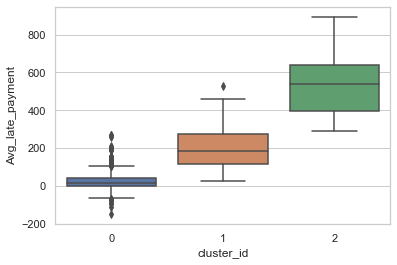

In [54]:
sns.boxplot(x='cluster_id', y='Avg_late_payment', data=df_clustering3)
plt.show()

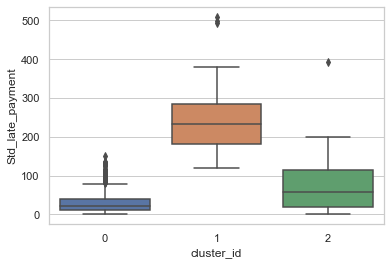

In [55]:
sns.boxplot(x='cluster_id', y='Std_late_payment', data=df_clustering3)
plt.show()

In [56]:
df_clustering3['cluster_id'].value_counts()

0    774
1     66
2     27
Name: cluster_id, dtype: int64

Customers belonging to Cluster Id 2 exhibit a higher likelihood of making late payments based on our analysis. It is crucial to prioritize collecting payments from these customers to mitigate the risk of delayed or outstanding payments.

In [57]:
df_payment['CUSTOMER_NAME'][df_payment['CUSTOMER_NUMBER'].isin(df_clustering3['CUSTOMER_NUMBER'][df_clustering3['cluster_id']==3])].drop_duplicates()

Series([], Name: CUSTOMER_NAME, dtype: object)

Given the higher propensity for late payments among customers in Cluster Id 2, it's imperative for the company to proactively safeguard its financial stability and mitigate potential risks.

In [58]:
# Need to keep an eye on the following customers as well
df_payment['CUSTOMER_NAME'][df_payment['CUSTOMER_NUMBER'].isin(df_clustering3['CUSTOMER_NUMBER'][df_clustering3['cluster_id']==1])].drop_duplicates()

3        FARO Corp
12       SEPH Corp
52       MAC  Corp
57       QATA Corp
78       CKG  Corp
           ...    
71116    BERL Corp
80125    NEST Corp
80462    BALS Corp
80602    EBDA Corp
88671    NOOR Corp
Name: CUSTOMER_NAME, Length: 61, dtype: object

### Lets Explore The Another Dataset Name As Open Invoice

In [59]:
df_OpenInvoice = pd.read_csv('Open_Invoice_data.csv', encoding = 'ISO-8859-1')

1) The ISO-8859-1 encoding, also known as Latin-1, is a widely used character encoding standard that supports a large range of characters from various languages, including most Western European languages.
2) It is chosen for datasets when the text contains characters outside the ASCII range, particularly accented characters or special symbols commonly found in languages such as French, Spanish, German, and others.
3) Using ISO-8859-1 ensures that these characters are correctly interpreted and displayed when reading the dataset into a Pandas DataFrame or other text-processing tools.

In [60]:
df_OpenInvoice.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [61]:
df_OpenInvoice.isnull().sum()

AS_OF_DATE              0
Customer Type           0
Customer_Name           0
Customer Account No     3
Transaction Number      9
Transaction Date        0
Payment Term            0
Due Date                0
Transaction Currency    0
Local Amount            0
Transaction Class       0
AGE                     0
USD Amount              0
INV_CREATION_DATE       0
dtype: int64

In [62]:
df_OpenInvoice['AS_OF_DATE'].value_counts()

04-APR-2022 01:07:01    88204
Name: AS_OF_DATE, dtype: int64

In [63]:
df_OpenInvoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


In [64]:
# To Find out difference between the below mentioned columns/Variables
df_OpenInvoice[['INV_CREATION_DATE','Transaction Date']]

,INV_CREATION_DATE,Transaction Date
0,12/21/2021 12:53,21/12/2021
1,2/1/2022 14:09,01/02/2022
2,3/24/2022 17:46,24/03/2022
3,1/5/2022 11:49,04/01/2022
4,3/3/2022 22:30,03/03/2022
...,...,...
88199,8/1/2021 15:33,01/08/2021
88200,8/1/2021 15:33,01/08/2021
88201,1/20/2022 10:41,20/01/2022
88202,1/18/2022 9:51,18/01/2022


In [65]:
# Convert the date variables from object to date type
# To Find out difference between the below mentioned columns/Variables
df_OpenInvoice['INV_CREATION_DATE'] = pd.to_datetime(df_OpenInvoice['INV_CREATION_DATE'])
df_OpenInvoice['Due Date'] = pd.to_datetime(df_OpenInvoice['Due Date'])
df_OpenInvoice['Transaction Date'] = pd.to_datetime(df_OpenInvoice['Transaction Date'])

In [66]:
df_OpenInvoice['USD Amount'] = df_OpenInvoice['USD Amount'].apply(lambda x: int(x.replace(",","")))

In [67]:
# Lets remove customers who have already made the payment (Consider only those whose age is negative)
df_OpenInvoice = df_OpenInvoice[(df_OpenInvoice['USD Amount']>0) & (df_OpenInvoice['AGE']<0)]

In [68]:
df_OpenInvoice.isnull().sum()

AS_OF_DATE              0
Customer Type           0
Customer_Name           0
Customer Account No     0
Transaction Number      0
Transaction Date        0
Payment Term            0
Due Date                0
Transaction Currency    0
Local Amount            0
Transaction Class       0
AGE                     0
USD Amount              0
INV_CREATION_DATE       0
dtype: int64

In [69]:
df_OpenInvoice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28015 entries, 2 to 88189
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AS_OF_DATE            28015 non-null  object        
 1   Customer Type         28015 non-null  object        
 2   Customer_Name         28015 non-null  object        
 3   Customer Account No   28015 non-null  float64       
 4   Transaction Number    28015 non-null  object        
 5   Transaction Date      28015 non-null  datetime64[ns]
 6   Payment Term          28015 non-null  object        
 7   Due Date              28015 non-null  datetime64[ns]
 8   Transaction Currency  28015 non-null  object        
 9   Local Amount          28015 non-null  object        
 10  Transaction Class     28015 non-null  object        
 11  AGE                   28015 non-null  int64         
 12  USD Amount            28015 non-null  int64         
 13  INV_CREATION_DAT

In [70]:
df_OpenInvoice['Customer Account No'] = df_OpenInvoice['Customer Account No'].apply(lambda x : int(x))

In [71]:
df_OpenInvoice['payment_term_days'] = df_OpenInvoice['Due Date'] -  df_OpenInvoice['INV_CREATION_DATE']
df_OpenInvoice['payment_term_days'] = df_OpenInvoice['payment_term_days'].apply(lambda x : x.days)

In [72]:
df_OpenInvoice['Transaction Class'].unique()

array(['INVOICE', 'DEBIT NOTE'], dtype=object)

In [73]:
df_prediction = df_OpenInvoice[['Customer Account No','USD Amount','payment_term_days']]

In [74]:
df_prediction

,Customer Account No,USD Amount,payment_term_days
2,23152,2000,29
4,7530,3800,57
5,7530,1264,57
6,7530,25858,45
7,7530,39873,45
...,...,...,...
88172,20867,3435,59
88186,23136,114039,89
88187,23136,32138,59
88188,23136,26764,59


In [75]:
#### Extract the same data from Past_payment_data (df_payment data)

df_classification = df_payment[['CUSTOMER_NUMBER', 'USD Amount','payment_term_days', 'Target_Variable']]

In [76]:
df_classification

,CUSTOMER_NUMBER,USD Amount,payment_term_days,Target_Variable
0,37403,101018.63040,58,True
1,4003,48990.21133,30,True
2,4003,41991.60971,30,False
3,1409,41991.60971,30,True
4,4003,41991.60971,30,True
...,...,...,...,...
93928,21144,59914.50000,57,False
93929,21144,59914.50000,60,True
93931,21144,59914.50000,54,True
93935,21145,23574.33000,59,True


In [77]:
df_classification.isnull().sum()

CUSTOMER_NUMBER      0
USD Amount           0
payment_term_days    0
Target_Variable      0
dtype: int64

In [78]:
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82887 entries, 0 to 93936
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUSTOMER_NUMBER    82887 non-null  int64  
 1   USD Amount         82887 non-null  float64
 2   payment_term_days  82887 non-null  int64  
 3   Target_Variable    82887 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 2.6 MB


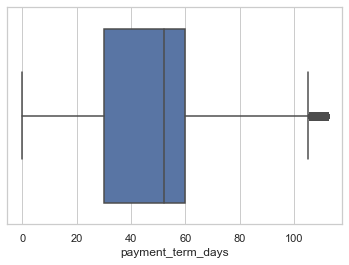

In [79]:
sns.boxplot(data=df_classification, x='payment_term_days')
plt.show()

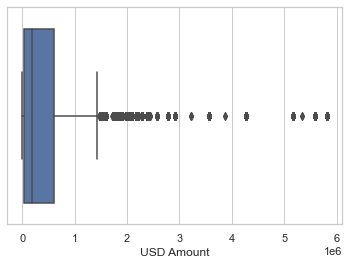

In [80]:
sns.boxplot(data=df_classification, x='USD Amount')
plt.show()

### Preprocessing Train Test Data for Model Building

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X = df_classification.drop(['Target_Variable','CUSTOMER_NUMBER'], axis=1)
y = df_classification['Target_Variable']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=80)

In [84]:
from sklearn.preprocessing import StandardScaler

In [85]:
SS = StandardScaler()

In [86]:
X_train[['USD Amount', 'payment_term_days']] = SS.fit_transform(X_train[['USD Amount', 'payment_term_days']])
X_train.head()

,USD Amount,payment_term_days
21636,-0.527129,0.456362
31734,2.380298,0.797420
29569,-0.471359,-2.101579
69493,-0.603723,-0.865241
93535,0.253749,-0.183124


### Building the Random Forest Model

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
from sklearn import metrics

In [89]:
RF = RandomForestClassifier(n_estimators = 10, max_depth = 4, random_state = 100, oob_score = True)

In [90]:
%%time
RF.fit(X_train, y_train)

CPU times: total: 328 ms
Wall time: 362 ms


RandomForestClassifier(max_depth=4, n_estimators=10, oob_score=True,
                       random_state=100)

In [91]:
RF.oob_score_

0.6922957600827301

In [92]:
import sklearn.metrics as metrics

In [93]:
def draw_roc(actuals, probs):
    fpr, tpr, thresholds =  metrics.roc_curve(actuals, probs, drop_intermediate = False)
    auc_score = metrics.auc(actuals, probs)
    plt.figure(figsize= (5,5))
    plt.plot(fpr, tpr, label = "ROC Curve (Area =%0.2f)" % auc_score)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc='lower right')
    plt.show()
    
    return None

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
RF = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [96]:
params = {
        'max_depth' : [2,3,5,10,20],
        'min_samples_leaf' : [5,10,20,50,100,200],
        'n_estimators' : [10,25,50,100]
         }

In [97]:
grid_search = GridSearchCV(estimator = RF,
                           param_grid = params,
                           cv = 4,
                           n_jobs = -1, verbose = 1, scoring = 'accuracy')

In [98]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
CPU times: total: 16.6 s
Wall time: 4min 16s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [99]:
grid_search.best_score_

0.825094794898311

In [100]:
RF_best = grid_search.best_estimator_
RF_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [101]:
RF_best.feature_importances_

array([0.65627023, 0.34372977])

In [102]:
imp_df = pd.DataFrame({
                       'Varname' :X_train.columns,
                       'Imp' : RF_best.feature_importances_
                        })

In [103]:
imp_df.sort_values(by='Imp', ascending = False)

,Varname,Imp
0,USD Amount,0.65627
1,payment_term_days,0.34373


In [104]:
X_test

,USD Amount,payment_term_days
61438,2.771600e+06,30
23628,2.101629e+06,68
47187,1.081915e+05,34
14344,1.655945e+05,60
9347,4.378924e+03,61
...,...,...
23953,8.156259e+05,90
25723,1.224990e+06,90
8055,2.636685e+05,0
62809,8.057885e+05,0


In [105]:
X_test[['USD Amount', 'payment_term_days']] = SS.transform(X_test[['USD Amount', 'payment_term_days']])

In [106]:
y_test_pred = RF_best.predict(X_test)

In [107]:
y_pred1 = pd.DataFrame(y_test_pred)

In [108]:
y_pred1.head()

,0
0,True
1,False
2,True
3,True
4,True


In [109]:
y_test_df = pd.DataFrame(y_test)

In [110]:
y_pred1.reset_index(drop = True, inplace = True)
y_test_df.reset_index(drop = True, inplace = True)

In [111]:
y_pred_final = pd.concat([y_test_df, y_pred1], axis = 1)

In [112]:
y_pred_final.head()

,Target_Variable,0
0,True,True
1,False,False
2,False,True
3,True,True
4,True,True


In [113]:
y_pred_final = y_pred_final.rename(columns = {0 : 'Default_predict'})

In [114]:
y_pred_final.head()

,Target_Variable,Default_predict
0,True,True
1,False,False
2,False,True
3,True,True
4,True,True


In [115]:
metrics.accuracy_score(y_pred_final.Target_Variable, y_pred_final.Default_predict)

0.8326295894156914

In [116]:
confusion2 = metrics.confusion_matrix(y_pred_final.Target_Variable, y_pred_final.Default_predict)
confusion2 

array([[ 6539,  2842],
       [ 1320, 14166]], dtype=int64)

### Predictions on Open Invoice dataset Using Random Forest Model - Based on the historical data, can you predict the likelihood of delayed payment against open invoices from the customers?

In [117]:
df_prediction.head()

,Customer Account No,USD Amount,payment_term_days
2,23152,2000,29
4,7530,3800,57
5,7530,1264,57
6,7530,25858,45
7,7530,39873,45


In [118]:
df_prediction[['USD Amount', 'payment_term_days']] = SS.transform(df_prediction[['USD Amount', 'payment_term_days']])

In [119]:
df_prediction['prediction'] = RF_best.predict(df_prediction[['USD Amount', 'payment_term_days']])

In [120]:
df_prediction.head()

,Customer Account No,USD Amount,payment_term_days,prediction
2,23152,-0.605402,-0.865241,True
4,7530,-0.603160,0.328465,True
5,7530,-0.606318,0.328465,True
6,7530,-0.575690,-0.183124,False
7,7530,-0.558237,-0.183124,True


In [121]:
df_OpenInvoice[['Customer Account No','Customer_Name','Transaction Number']][df_prediction.prediction == True]

,Customer Account No,Customer_Name,Transaction Number
2,23152,AL J Corp,100220000143
4,7530,ALLI Corp,100220000105
5,7530,ALLI Corp,100220000106
7,7530,ALLI Corp,100220000125
8,7530,ALLI Corp,100220000128
...,...,...,...
88171,20867,MIDD Corp,165220000038
88172,20867,MIDD Corp,165220000039
88187,23136,SAUD Corp,165220000034
88188,23136,SAUD Corp,165220000035


###### As per the above results, ~88% customers(see names summary above) are potential once that Schuester need to review with - Can you draw any business insights based on your developed model?

#### Build Model Using Logistic Regression

In [122]:
df1= pd.read_csv('Received_Payments_Data.csv')

In [123]:
df3=pd.read_excel('Data+Dictionary.xlsx', header=None)

In [124]:
df1 = df1.loc[df1['Local Amount']>0]

In [125]:
df1['RECEIPT_METHOD'].value_counts()

WIRE             83281
AP/AR Netting     4847
CHEQUE            3472
CASH               782
I/C WIRE           211
PDC                210
I/C Check            6
I/C CASH             2
Name: RECEIPT_METHOD, dtype: int64

In [126]:
df1.loc[df1['RECEIPT_METHOD'] == 'I/C Check', 'RECEIPT_METHOD' ] = 'CHEQUE'
df1.loc[df1['RECEIPT_METHOD'] == 'I/C CASH', 'RECEIPT_METHOD' ] = 'CASH'
df1.loc[df1['RECEIPT_METHOD'] == 'I/C WIRE', 'RECEIPT_METHOD' ] = 'WIRE'

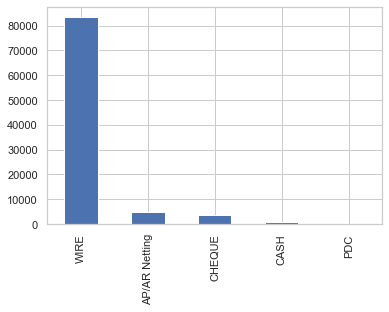

In [127]:
df1.RECEIPT_METHOD.value_counts().plot(kind='bar')
plt.show()

In [128]:
df1.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DOC_NO',
       'RECEIPT_DATE', 'CLASS', 'CURRENCY_CODE', 'Local Amount', 'USD Amount',
       'INVOICE_ALLOCATED', 'INVOICE_CREATION_DATE', 'DUE_DATE',
       'PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE'],
      dtype='object')

In [129]:
df1 = df1[['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DOC_NO',
       'RECEIPT_DATE', 'CLASS', 'CURRENCY_CODE', 'Local Amount', 'USD Amount',
       'INVOICE_ALLOCATED', 'INVOICE_CREATION_DATE', 'DUE_DATE',
       'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE','INVOICE_TYPE']]

In [130]:
df1['DUE_DATE'] = pd.to_datetime(df1['DUE_DATE'])
df1['RECEIPT_DATE'] = pd.to_datetime(df1['RECEIPT_DATE'])
df1['INVOICE_CREATION_DATE'] = pd.to_datetime(df1['INVOICE_CREATION_DATE'])

In [131]:
df1['late_days'] = df1['RECEIPT_DATE'] - df1['DUE_DATE']
df1['payment_term'] = df1['DUE_DATE'] - df1['INVOICE_CREATION_DATE']

In [132]:
df1['Target_Variable'] = df1['late_days'] > pd.Timedelta(days=0)

In [133]:
df1 = df1.drop(columns = ['RECEIPT_DATE','DUE_DATE','late_days','INVOICE_CREATION_DATE'])

In [134]:
df1[df1.payment_term < pd.Timedelta(days=0)]

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DOC_NO,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,payment_term,Target_Variable
148,WIRE,RADW Corp,1.000000e+11,PMT,USD,2345.81,2345.810000,1.0021E+11,INV,AED,Non Goods,-1 days,True
152,WIRE,RADW Corp,1.000000e+11,PMT,USD,2345.81,2345.810000,1.0021E+11,INV,AED,Non Goods,-1 days,True
160,WIRE,REAL Corp,1.000000e+11,PMT,AED,98247.31,98247.310000,PAY1001522100494,INV,AED,Non Goods,-30 days,True
161,WIRE,REAL Corp,1.000000e+11,PMT,AED,98247.31,98247.310000,PAY1001522100496,CM,AED,Non Goods,-30 days,True
167,WIRE,RADW Corp,1.000000e+11,PMT,AED,10861.54,10861.540000,1.0021E+11,INV,AED,Non Goods,-1 days,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93484,WIRE,THE Corp,2.840000e+11,PMT,AED,2389.27,2389.270000,2.842E+11,CM,AED,Goods,-5 days,True
93575,WIRE,SERB Corp,2.910000e+11,PMT,SAR,68512.00,18266.216920,10142,INV,SAR,Non Goods,-102 days,True
93576,WIRE,SERB Corp,2.910000e+11,PMT,SAR,68512.00,18266.216920,10141,INV,SAR,Non Goods,-102 days,True
93903,WIRE,SCOP Corp,2.970000e+11,PMT,AED,23875.00,6501.021103,2.9721E+11,INV,AED,Non Goods,-3 days,True


For over 3000 entries, the payment was made before the invoice was generated. Such entries can be dropped from the dataset to maintain data integrity and accuracy.

In [135]:
df1 = df1[df1.payment_term >=pd.Timedelta(days=0)]

In [136]:
df1 = df1.drop(columns = ['RECEIPT_DOC_NO','INVOICE_ALLOCATED','CUSTOMER_NAME','Local Amount','CURRENCY_CODE'])

In [137]:
df1['INVOICE_TYPE'] = df1['INVOICE_TYPE'].map({'Goods' :1, 'Non Goods' : 0 })

In [138]:
# Create dummy variable for some of the Categorical Variables and dropping the first one
dummy1 = pd.get_dummies(df1[['RECEIPT_METHOD','CLASS','INVOICE_CLASS','INVOICE_CURRENCY_CODE']], drop_first= True)

In [139]:
# Add the result to the master dataframe
df2 = pd.concat([df1, dummy1], axis = 1)

In [140]:
df2 = df2.drop(columns = ['RECEIPT_METHOD','CLASS','INVOICE_CLASS','INVOICE_CURRENCY_CODE'])

In [141]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89552 entries, 0 to 93936
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   USD Amount                 89552 non-null  float64        
 1   INVOICE_TYPE               89552 non-null  int64          
 2   payment_term               89552 non-null  timedelta64[ns]
 3   Target_Variable            89552 non-null  bool           
 4   RECEIPT_METHOD_CASH        89552 non-null  uint8          
 5   RECEIPT_METHOD_CHEQUE      89552 non-null  uint8          
 6   RECEIPT_METHOD_PDC         89552 non-null  uint8          
 7   RECEIPT_METHOD_WIRE        89552 non-null  uint8          
 8   INVOICE_CLASS_DM           89552 non-null  uint8          
 9   INVOICE_CLASS_INV          89552 non-null  uint8          
 10  INVOICE_CURRENCY_CODE_BHD  89552 non-null  uint8          
 11  INVOICE_CURRENCY_CODE_EUR  89552 non-null  uint8      

In [142]:
df2['USD Amount'].describe(percentiles = [0.25,0.5, 0.75, 0.90, 0.95, 0.99])

count    8.955200e+04
mean     5.470055e+05
std      9.586061e+05
min      1.287743e+00
25%      4.050662e+04
50%      2.000138e+05
75%      6.036712e+05
90%      1.257455e+06
95%      2.101629e+06
99%      5.814128e+06
max      1.084983e+07
Name: USD Amount, dtype: float64

In [143]:
df2['payment_term'].describe(percentiles = [0.25,0.5, 0.75, 0.90, 0.95, 0.99])

count                         89552
mean     47 days 13:09:18.299088797
std      26 days 06:53:18.987795171
min                 0 days 00:00:00
25%                30 days 00:00:00
50%                47 days 00:00:00
75%                60 days 00:00:00
90%                82 days 00:00:00
95%                90 days 00:00:00
99%               112 days 00:00:00
max               365 days 00:00:00
Name: payment_term, dtype: object

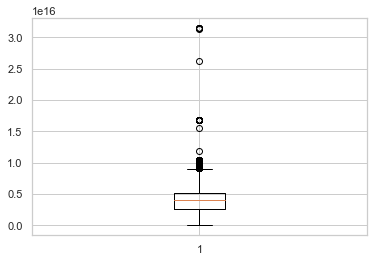

In [144]:
plt.boxplot(df2['payment_term'])
plt.show()

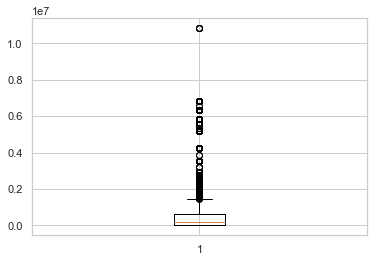

In [145]:
plt.boxplot(df2['USD Amount'])
plt.show()

In [146]:
df2.payment_term = df2.payment_term.apply(lambda x : x.days)

### Train Test Data

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [148]:
X=df2.drop(['Target_Variable'], axis = 1)
X.head()

,USD Amount,INVOICE_TYPE,payment_term,RECEIPT_METHOD_CASH,RECEIPT_METHOD_CHEQUE,RECEIPT_METHOD_PDC,RECEIPT_METHOD_WIRE,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
0,101018.63040,0,58,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,48990.21133,0,30,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,41991.60971,0,30,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,41991.60971,0,30,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,41991.60971,0,30,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [149]:
y=df2['Target_Variable']
y.head()

0     True
1     True
2    False
3     True
4     True
Name: Target_Variable, dtype: bool

In [150]:
X_train,X_test, y_train,y_test = train_test_split(X,y, train_size=0.70, random_state=100)

In [151]:
X_train[['USD Amount', 'payment_term']] = SS.fit_transform(X_train[['USD Amount', 'payment_term']])

In [152]:
X_train.head()

,USD Amount,INVOICE_TYPE,payment_term,RECEIPT_METHOD_CASH,RECEIPT_METHOD_CHEQUE,RECEIPT_METHOD_PDC,RECEIPT_METHOD_WIRE,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
45314,-0.563953,1,-0.671587,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
92954,0.146644,1,0.474167,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
75003,-0.538346,0,-0.442436,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
12562,-0.546697,0,0.474167,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
41635,-0.556113,1,0.435976,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [153]:
AnAa = (sum(df2['Target_Variable'])/len(df2['Target_Variable'].index))*100
AnAa

64.46310523494729

### HeatMap

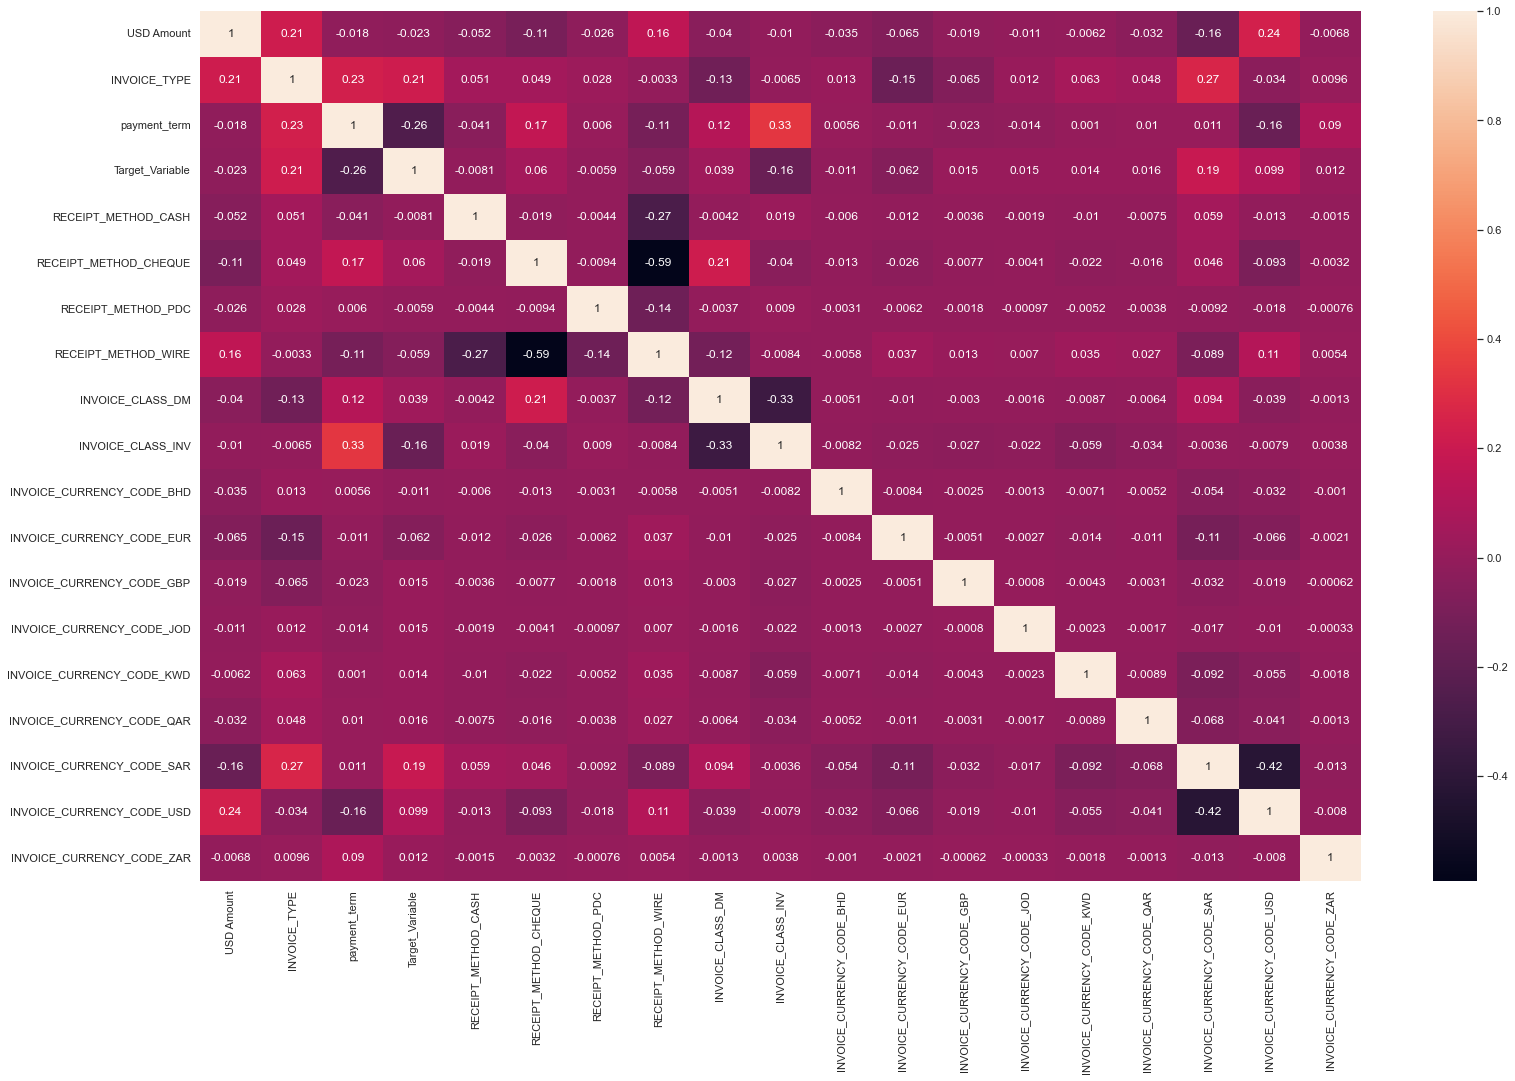

In [154]:
plt.figure(figsize = [26,16])
sns.heatmap(df2.corr(), annot = True)
plt.show()

There is no need to drop any variables since no high correlation is observed between them.

In [155]:
import statsmodels.api as sm

In [156]:
# Logistics Regression Model
LR1 = sm.GLM(y_train, (sm.add_constant(X_train)), family =sm.families.Binomial())
LR1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Target_Variable   No. Observations:                62686
Model:                            GLM   Df Residuals:                    62667
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33233.
Date:                Thu, 30 May 2024   Deviance:                       66467.
Time:                        20:05:02   Pearson chi2:                 6.45e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2134
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.3774      0.145      9.484      0.000       1.093       1.662
USD Amount                   -0.2349      0.011    -22.268      0.000      -0.256      -0.214
INVOICE_TYPE                  1.6939      0.027     63.549      0.000       1.642       1.746
payment_term                 -0.8992      0.013    -69.410      0.000      -0.925      -0.874
RECEIPT_METHOD_CASH          -1.9146      0.106    -18.004      0.000      -2.123      -1.706
RECEIPT_METHOD_CHEQUE         0.5759      0.069      8.326      0.000       0.440       0.711
RECEIPT_METHOD_PDC           -0.7849      0.205     -3.832      0.000      -1.186      -0.383
RECEIPT_METHOD_WIRE          -0.6648      0.044    -15.178      0.000      -0.751      -0.579
INVOICE_CLASS_DM              1.3616      0.223      6.105      0.000       0.924       1.799
INVOICE_CLASS_INV            -1.7885      0.138    -12.924      0.000      -2.060      -1.517
INVOICE_CURRENCY_CODE_BHD    -0.1436      0.132     -1.085      0.278      -0.403       0.116
INVOICE_CURRENCY_CODE_EUR    -0.0162      0.079     -0.207      0.836      -0.170       0.138
INVOICE_CURRENCY_CODE_GBP     2.2632      0.280      8.076      0.000       1.714       2.812
INVOICE_CURRENCY_CODE_JOD    22.2638    1.5e+04      0.001      0.999   -2.94e+04    2.94e+04
INVOICE_CURRENCY_CODE_KWD     0.3897      0.089      4.371      0.000       0.215       0.564
INVOICE_CURRENCY_CODE_QAR     0.5343      0.120      4.465      0.000       0.300       0.769
INVOICE_CURRENCY_CODE_SAR     0.6925      0.023     30.708      0.000       0.648       0.737
INVOICE_CURRENCY_CODE_USD     0.9963      0.028     35.683      0.000       0.942       1.051
INVOICE_CURRENCY_CODE_ZAR    27.9110   2.51e+04      0.001      0.999   -4.92e+04    4.93e+04
=============================================================================================
"""

The p-value of 'INVOICE_CURRENCY_CODE_ZAR' is very high. The correlation coefficient with USD is also high, so we should drop it and assess if it affects the model accuracy.

In [157]:
X_train = X_train.drop(['INVOICE_CURRENCY_CODE_ZAR','INVOICE_CURRENCY_CODE_JOD','INVOICE_CURRENCY_CODE_EUR',
                        'INVOICE_CURRENCY_CODE_BHD'], 1)
X_test = X_test.drop(['INVOICE_CURRENCY_CODE_ZAR','INVOICE_CURRENCY_CODE_JOD','INVOICE_CURRENCY_CODE_EUR',
                        'INVOICE_CURRENCY_CODE_BHD'],1)

In [158]:
LR2 = sm.GLM(y_train, (sm.add_constant(X_train)), family =sm.families.Binomial())
res2 = LR2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Target_Variable   No. Observations:                62686
Model:                            GLM   Df Residuals:                    62671
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33284.
Date:                Thu, 30 May 2024   Deviance:                       66567.
Time:                        20:08:57   Pearson chi2:                 6.50e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2122
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.3884      0.145      9.583      0.000       1.104       1.672
USD Amount                   -0.2349      0.011    -22.355      0.000      -0.255      -0.214
INVOICE_TYPE                  1.6884      0.026     63.715      0.000       1.636       1.740
payment_term                 -0.8914      0.013    -69.045      0.000      -0.917      -0.866
RECEIPT_METHOD_CASH          -1.9055      0.106    -17.938      0.000      -2.114      -1.697
RECEIPT_METHOD_CHEQUE         0.5733      0.069      8.302      0.000       0.438       0.709
RECEIPT_METHOD_PDC           -0.7806      0.205     -3.816      0.000      -1.182      -0.380
RECEIPT_METHOD_WIRE          -0.6602      0.044    -15.104      0.000      -0.746      -0.574
INVOICE_CLASS_DM              1.3360      0.223      5.997      0.000       0.899       1.773
INVOICE_CLASS_INV            -1.8014      0.138    -13.037      0.000      -2.072      -1.531
INVOICE_CURRENCY_CODE_GBP     2.2584      0.280      8.064      0.000       1.709       2.807
INVOICE_CURRENCY_CODE_KWD     0.3883      0.089      4.360      0.000       0.214       0.563
INVOICE_CURRENCY_CODE_QAR     0.5335      0.120      4.461      0.000       0.299       0.768
INVOICE_CURRENCY_CODE_SAR     0.6930      0.022     31.048      0.000       0.649       0.737
INVOICE_CURRENCY_CODE_USD     0.9967      0.028     35.942      0.000       0.942       1.051
=============================================================================================
"""

In [159]:
y_train_pred = res2.predict((sm.add_constant(X_train)))
y_train_pred[ : 10]

45314    0.884857
92954    0.700792
75003    0.609297
12562    0.203040
41635    0.740808
43384    0.899263
87750    0.694048
3084     0.924021
61492    0.988860
82725    0.632323
dtype: float64

In [160]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[ :10]

array([0.88485676, 0.7007924 , 0.60929693, 0.20304017, 0.74080825,
       0.89926274, 0.6940476 , 0.92402062, 0.98886037, 0.63232311])

In [161]:
y_train_pred_final = pd.DataFrame({'Actual_Default' : y_train.values, 'default_Prob' : y_train_pred})
y_train_pred_final.head()

,Actual_Default,default_Prob
0,True,0.884857
1,False,0.700792
2,False,0.609297
3,True,0.203040
4,True,0.740808


In [162]:
y_train_pred_final['predicted_default'] = y_train_pred_final.default_Prob.map(lambda x : 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Actual_Default,default_Prob,predicted_default
0,True,0.884857,1
1,False,0.700792,1
2,False,0.609297,1
3,True,0.203040,0
4,True,0.740808,1


In [163]:
from sklearn import metrics

In [164]:
confusion = metrics.confusion_matrix(y_train_pred_final.Actual_Default, y_train_pred_final.predicted_default)
print(confusion)

[[11729 10493]
 [ 6471 33993]]


In [165]:
print(metrics.accuracy_score(y_train_pred_final.Actual_Default, y_train_pred_final.predicted_default))

0.7293813610694573


In [166]:
# Lets consider the VIF values of the Feature variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [167]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
6,RECEIPT_METHOD_WIRE,11.89
8,INVOICE_CLASS_INV,11.68
1,INVOICE_TYPE,4.85
12,INVOICE_CURRENCY_CODE_SAR,2.50
13,INVOICE_CURRENCY_CODE_USD,1.68
4,RECEIPT_METHOD_CHEQUE,1.56
2,payment_term,1.28
7,INVOICE_CLASS_DM,1.21
0,USD Amount,1.16
3,RECEIPT_METHOD_CASH,1.14


In [168]:
X_test = X_test.drop(['INVOICE_CLASS_INV'],1)
X_train = X_train.drop(['INVOICE_CLASS_INV'],1)

The operation is performed to remove the 'INVOICE_CLASS_INV' feature from the training and testing datasets, possibly because it is not relevant or useful for the model, or to prevent issues related to multicollinearity or overfitting.

In [169]:
LR3 = sm.GLM(y_train, (sm.add_constant(X_train)), family = sm.families.Binomial())
res3 = LR3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Target_Variable   No. Observations:                62686
Model:                            GLM   Df Residuals:                    62672
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33426.
Date:                Thu, 30 May 2024   Deviance:                       66852.
Time:                        20:14:39   Pearson chi2:                 6.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2086
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.4049      0.045     -8.993      0.000      -0.493      -0.317
USD Amount                   -0.2338      0.011    -22.239      0.000      -0.254      -0.213
INVOICE_TYPE                  1.7442      0.026     66.648      0.000       1.693       1.796
payment_term                 -0.9545      0.012    -77.211      0.000      -0.979      -0.930
RECEIPT_METHOD_CASH          -1.9604      0.107    -18.382      0.000      -2.169      -1.751
RECEIPT_METHOD_CHEQUE         0.6046      0.069      8.708      0.000       0.469       0.741
RECEIPT_METHOD_PDC           -0.8088      0.206     -3.929      0.000      -1.212      -0.405
RECEIPT_METHOD_WIRE          -0.6645      0.044    -15.128      0.000      -0.751      -0.578
INVOICE_CLASS_DM              3.2423      0.172     18.854      0.000       2.905       3.579
INVOICE_CURRENCY_CODE_GBP     2.3285      0.277      8.391      0.000       1.785       2.872
INVOICE_CURRENCY_CODE_KWD     0.4064      0.088      4.616      0.000       0.234       0.579
INVOICE_CURRENCY_CODE_QAR     0.5371      0.119      4.529      0.000       0.305       0.769
INVOICE_CURRENCY_CODE_SAR     0.6700      0.022     30.157      0.000       0.626       0.714
INVOICE_CURRENCY_CODE_USD     0.9789      0.028     35.266      0.000       0.924       1.033
=============================================================================================
"""

In [170]:
X_train = X_train.drop(['RECEIPT_METHOD_WIRE'],1)
X_test = X_test.drop(['RECEIPT_METHOD_WIRE'],1)

This operation ensures that the 'RECEIPT_METHOD_WIRE' feature will not be included in the model training or prediction processes.

In [171]:
LR4 = sm.GLM(y_train, (sm.add_constant(X_train)), family = sm.families.Binomial())
res4 = LR4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Target_Variable   No. Observations:                62686
Model:                            GLM   Df Residuals:                    62673
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33546.
Date:                Thu, 30 May 2024   Deviance:                       67092.
Time:                        20:16:34   Pearson chi2:                 6.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2055
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.0152      0.020    -50.585      0.000      -1.055      -0.976
USD Amount                   -0.2441      0.010    -23.343      0.000      -0.265      -0.224
INVOICE_TYPE                  1.7118      0.026     65.894      0.000       1.661       1.763
payment_term                 -0.9416      0.012    -76.790      0.000      -0.966      -0.918
RECEIPT_METHOD_CASH          -1.3317      0.098    -13.608      0.000      -1.524      -1.140
RECEIPT_METHOD_CHEQUE         1.2175      0.056     21.639      0.000       1.107       1.328
RECEIPT_METHOD_PDC           -0.1798      0.201     -0.893      0.372      -0.574       0.215
INVOICE_CLASS_DM              3.1664      0.172     18.441      0.000       2.830       3.503
INVOICE_CURRENCY_CODE_GBP     2.2670      0.277      8.180      0.000       1.724       2.810
INVOICE_CURRENCY_CODE_KWD     0.3799      0.088      4.319      0.000       0.207       0.552
INVOICE_CURRENCY_CODE_QAR     0.5063      0.119      4.272      0.000       0.274       0.739
INVOICE_CURRENCY_CODE_SAR     0.6848      0.022     30.873      0.000       0.641       0.728
INVOICE_CURRENCY_CODE_USD     0.9681      0.028     34.998      0.000       0.914       1.022
=============================================================================================
"""

In [172]:
X_train = X_train[['USD Amount','payment_term']]
X_test = X_test[['USD Amount','payment_term']]

This operation effectively removes all other columns from X_train and X_test, ensuring that only 'USD Amount' and 'payment_term' are used in the subsequent analysis or modeling steps. This might be done to simplify the model, reduce computational complexity, or focus on the most relevant features.

In [173]:
LR5 = sm.GLM(y_train, (sm.add_constant(X_train)), family = sm.families.Binomial())
res5 = LR5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Target_Variable   No. Observations:                62686
Model:                            GLM   Df Residuals:                    62683
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38472.
Date:                Thu, 30 May 2024   Deviance:                       76944.
Time:                        20:18:24   Pearson chi2:                 6.19e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07032
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6462      0.009     73.656      0.000       0.629       0.663
USD Amount      -0.0695      0.009     -8.001      0.000      -0.087      -0.053
payment_term    -0.5910      0.009    -63.785      0.000      -0.609      -0.573
================================================================================
"""

In [174]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
# vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,USD Amount,1.0
1,payment_term,1.0


In [175]:
y_train_pred = res5.predict((sm.add_constant(X_train)))
y_train_pred[ :10]

45314    0.746930
92954    0.588000
75003    0.720126
12562    0.599628
41635    0.605191
43384    0.766586
87750    0.585705
3084     0.801091
61492    0.826108
82725    0.326151
dtype: float64

In [176]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[ :10]

array([0.74693029, 0.58799957, 0.72012622, 0.59962789, 0.60519117,
       0.76658576, 0.58570517, 0.80109103, 0.82610813, 0.32615133])

In [177]:
y_train_pred_final = pd.DataFrame({'Actual_Default' : y_train.values, 'default_Prob' : y_train_pred})
y_train_pred_final.head()

,Actual_Default,default_Prob
0,True,0.746930
1,False,0.588000
2,False,0.720126
3,True,0.599628
4,True,0.605191


In [178]:
y_train_pred_final['predicted_default'] = y_train_pred_final.default_Prob.map(lambda x : 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Actual_Default,default_Prob,predicted_default
0,True,0.746930,1
1,False,0.588000,1
2,False,0.720126,1
3,True,0.599628,1
4,True,0.605191,1


In [179]:
confusion = metrics.confusion_matrix(y_train_pred_final.Actual_Default, y_train_pred_final.predicted_default)
print(confusion)

[[ 4915 17307]
 [ 3818 36646]]


In [180]:
print(metrics.accuracy_score(y_train_pred_final.Actual_Default, y_train_pred_final.predicted_default))

0.6630029033596018


In [181]:
# For accessing the ROC_curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize = (8,8))
    plt.plot(fpr, tpr, label='ROC curve (area = % 0.2f)' % auc_score)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1- True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc = "lower right")
    plt.show()
    
    return None

In [182]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Actual_Default, y_train_pred_final.default_Prob, drop_intermediate = False)

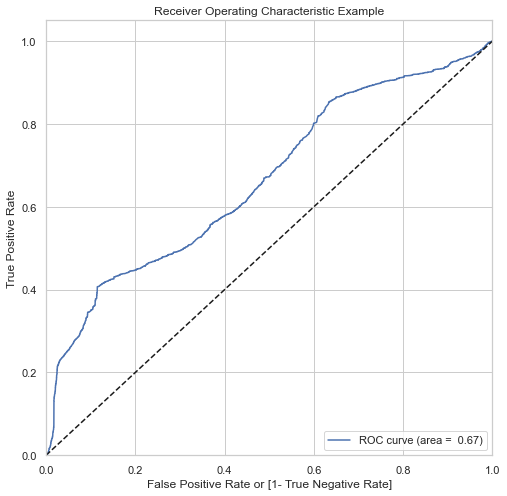

In [183]:
draw_roc(y_train_pred_final.Actual_Default, y_train_pred_final.default_Prob)

In [184]:
# Create columns with different porbabilities cut-off
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.default_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()    

,Actual_Default,default_Prob,predicted_default,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,True,0.746930,1,1,1,1,1,1,1,1,1,0,0
1,False,0.588000,1,1,1,1,1,1,1,0,0,0,0
2,False,0.720126,1,1,1,1,1,1,1,1,1,0,0
3,True,0.599628,1,1,1,1,1,1,1,0,0,0,0
4,True,0.605191,1,1,1,1,1,1,1,1,0,0,0


In [185]:
# Lets calculate accuracy, sensitivity and specificity for various probabilities cut-off
cutoff_df = pd.DataFrame(columns = ['probs','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # True Positive
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive  
# FN = confusion[1,0] # False Negative

num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Actual_Default, y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i, accuracy, sensitivity, specificity]
print(cutoff_df)

     probs  accuracy  sensitivity  specificity
0.0    0.0  0.645503     1.000000     0.000000
0.1    0.1  0.645375     0.999728     0.000135
0.2    0.2  0.645375     0.999728     0.000135
0.3    0.3  0.645774     0.995255     0.009405
0.4    0.4  0.639313     0.968120     0.040590
0.5    0.5  0.663003     0.905645     0.221177
0.6    0.6  0.591982     0.614398     0.551166
0.7    0.7  0.569872     0.483714     0.726757
0.8    0.8  0.446352     0.153321     0.979930
0.9    0.9  0.354497     0.000000     1.000000


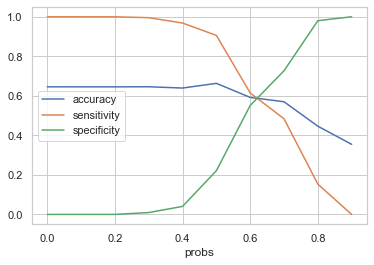

In [186]:
# Lets plot accuracy sensitivity and specificity for various probabilities
cutoff_df.plot.line(x='probs', y=['accuracy','sensitivity','specificity'])
plt.show()

We need high sensitivity model so from the curve above optimum values for cutoff looks like 0.5

In [187]:
y_train_pred_final['final_predicted'] = y_train_pred_final.default_Prob.map(lambda x : 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Actual_Default,default_Prob,predicted_default,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,True,0.746930,1,1,1,1,1,1,1,1,1,0,0,1
1,False,0.588000,1,1,1,1,1,1,1,0,0,0,0,1
2,False,0.720126,1,1,1,1,1,1,1,1,1,0,0,1
3,True,0.599628,1,1,1,1,1,1,1,0,0,0,0,1
4,True,0.605191,1,1,1,1,1,1,1,1,0,0,0,1


In [188]:
metrics.accuracy_score(y_train_pred_final.Actual_Default, y_train_pred_final.predicted_default)

0.6630029033596018

In [189]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Actual_Default, y_train_pred_final.predicted_default)
print(confusion2)

[[ 4915 17307]
 [ 3818 36646]]


In [190]:
TP = confusion2[1,1] # True Positive
TN = confusion2[0,0] # True Negative
FP = confusion2[0,1] # False Positive  
FN = confusion2[1,0] # False Negative

In [191]:
# Lets have a look at sensitivity of our model
TP/float(TP+FN)

0.9056445235270858

With a model sensitivity of 90%, we anticipate identifying approximately 9,318 defaults and around 10,000 non-defaulters.

In [192]:
X_test[['USD Amount', 'payment_term']] = SS.transform(X_test[['USD Amount', 'payment_term']])

In [193]:
X_test.head()

,USD Amount,payment_term
60181,5.271759,-0.671587
37676,-0.537644,-0.671587
59038,0.528853,-1.817341
5869,-0.567221,-1.817341
41106,-0.419445,-0.900738


In [194]:
X_test_sm = sm.add_constant(X_test)

In [195]:
y_test_pred = res5.predict(X_test_sm)

In [196]:
y_test_pred[ :10]

60181    0.662959
37676    0.746584
59038    0.843368
5869     0.853175
41106    0.769891
59181    0.830098
25948    0.410786
79788    0.437932
19368    0.583906
79298    0.533005
dtype: float64

In [197]:
y_pred_1 = pd.DataFrame(y_test_pred)

In [198]:
y_pred_1.head()

,0
60181,0.662959
37676,0.746584
59038,0.843368
5869,0.853175
41106,0.769891


In [199]:
y_test_df = pd.DataFrame(y_test)

In [200]:
y_test_df['CustID'] = y_test_df.index

In [201]:
# Remove index from both dataframes to combine them together
y_pred_1.reset_index(drop = True, inplace = True)
y_test_df.reset_index(drop = True, inplace = True)

In [202]:
# Combining data y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis = 1)

In [203]:
# Rename column 0 to default_Prob
y_pred_final = y_pred_final.rename(columns = {0 : 'default_Prob'})

In [204]:
y_pred_final.head()

,Target_Variable,CustID,default_Prob
0,False,60181,0.662959
1,True,37676,0.746584
2,True,59038,0.843368
3,True,5869,0.853175
4,True,41106,0.769891


In [205]:
y_pred_final['final_predicted'] = y_pred_final.default_Prob.map(lambda x : 1 if x > 0.5 else 0)

In [206]:
y_pred_final.head()

,Target_Variable,CustID,default_Prob,final_predicted
0,False,60181,0.662959,1
1,True,37676,0.746584,1
2,True,59038,0.843368,1
3,True,5869,0.853175,1
4,True,41106,0.769891,1


In [207]:
# Check for overall accuracy
metrics.accuracy_score(y_pred_final.Target_Variable, y_pred_final.final_predicted)

0.6598674905084494

In [208]:
confusion2 = metrics.confusion_matrix(y_pred_final.Target_Variable, y_pred_final.final_predicted)
print(confusion2)

[[ 2101  7501]
 [ 1637 15627]]


In [209]:
TP = confusion2[1,1] # True Positive
TN = confusion2[0,0] # True Negative
FP = confusion2[0,1] # False Positive  
FN = confusion2[1,0] # False Negative

In [210]:
# Lets have a look at sensitivity of our model
TP/float(TP+FN)

0.905178405931418

In [211]:
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Target_Variable   No. Observations:                62686
Model:                            GLM   Df Residuals:                    62683
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38472.
Date:                Thu, 30 May 2024   Deviance:                       76944.
Time:                        20:35:28   Pearson chi2:                 6.19e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07032
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6462      0.009     73.656      0.000       0.629       0.663
USD Amount      -0.0695      0.009     -8.001      0.000      -0.087      -0.053
payment_term    -0.5910      0.009    -63.785      0.000      -0.609      -0.573
================================================================================
"""

In [212]:
# Preparing Open Invoice dataset for prediction
df_OpenInvoice2 = pd.read_csv('Open_Invoice_data.csv', encoding = 'ISO-8859-1')

In [213]:
df_OpenInvoice2.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [214]:
df_OpenInvoice2['INV_CREATION_DATE'] = pd.to_datetime(df_OpenInvoice2['INV_CREATION_DATE'])
df_OpenInvoice2['Due Date'] = pd.to_datetime(df_OpenInvoice2['Due Date'])
df_OpenInvoice2['Transaction Date'] = pd.to_datetime(df_OpenInvoice2['Transaction Date'])

In [215]:
df_OpenInvoice2['USD Amount'] = df_OpenInvoice2['USD Amount'].apply(lambda x : int(x.replace(",","")))

In [216]:
# Remove customers who have already made the payment
df_OpenInvoice2 =df_OpenInvoice2[(df_OpenInvoice2['USD Amount'] >0) & (df_OpenInvoice2['AGE'] <0)] 

In [217]:
df_OpenInvoice2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28015 entries, 2 to 88189
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AS_OF_DATE            28015 non-null  object        
 1   Customer Type         28015 non-null  object        
 2   Customer_Name         28015 non-null  object        
 3   Customer Account No   28015 non-null  float64       
 4   Transaction Number    28015 non-null  object        
 5   Transaction Date      28015 non-null  datetime64[ns]
 6   Payment Term          28015 non-null  object        
 7   Due Date              28015 non-null  datetime64[ns]
 8   Transaction Currency  28015 non-null  object        
 9   Local Amount          28015 non-null  object        
 10  Transaction Class     28015 non-null  object        
 11  AGE                   28015 non-null  int64         
 12  USD Amount            28015 non-null  int64         
 13  INV_CREATION_DAT

In [218]:
df_OpenInvoice2['Customer Account No'] = df_OpenInvoice2['Customer Account No'].apply(lambda x : int(x))

In [219]:
df_OpenInvoice2['payment_term'] = df_OpenInvoice2['Due Date'] - df_OpenInvoice2['INV_CREATION_DATE']
df_OpenInvoice2['payment_term'] = df_OpenInvoice2['payment_term'].apply(lambda x:x.days)

The columns that are present in our past payment data
USD Amount &
payment_term

In [220]:
df_OpenInvoice2

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,payment_term
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152,100220000143,2022-03-24,30 Days from Inv Date,2022-04-23,USD,"2,000",INVOICE,-18,2000,2022-03-24 17:46:00,29
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530,100220000105,2022-03-03,30 Days from EOM,2022-04-30,AED,"3,800",INVOICE,-25,3800,2022-03-03 22:30:00,57
5,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530,100220000106,2022-03-03,30 Days from EOM,2022-04-30,AED,"1,264",INVOICE,-25,1264,2022-03-03 22:30:00,57
6,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530,100220000124,2022-03-15,30 Days from EOM,2022-04-30,AED,"25,858",INVOICE,-25,25858,2022-03-15 19:06:00,45
7,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530,100220000125,2022-03-15,30 Days from EOM,2022-04-30,AED,"39,873",INVOICE,-25,39873,2022-03-15 19:06:00,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88172,04-APR-2022 01:07:01,3rd Party,MIDD Corp,20867,165220000039,2022-03-30,60 Days from Inv Date,2022-05-29,USD,"3,435",INVOICE,-54,3435,2022-03-30 11:10:00,59
88186,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136,165220000032,2022-07-03,60 Days from Inv Date,2022-06-05,USD,"114,039",INVOICE,-31,114039,2022-03-07 09:58:00,89
88187,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136,165220000034,2022-03-17,60 Days from Inv Date,2022-05-16,USD,"32,138",INVOICE,-41,32138,2022-03-17 08:21:00,59
88188,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136,165220000035,2022-03-18,60 Days from Inv Date,2022-05-17,USD,"26,764",INVOICE,-42,26764,2022-03-18 10:48:00,59


In [221]:
df_prediction = df_OpenInvoice2[['Customer Account No', 'USD Amount','payment_term']]

In [222]:
df_prediction2 = df_prediction.drop(['Customer Account No'],1)

In [223]:
df_prediction2

,USD Amount,payment_term
2,2000,29
4,3800,57
5,1264,57
6,25858,45
7,39873,45
...,...,...
88172,3435,59
88186,114039,89
88187,32138,59
88188,26764,59


In [224]:
df_prediction

,Customer Account No,USD Amount,payment_term
2,23152,2000,29
4,7530,3800,57
5,7530,1264,57
6,7530,25858,45
7,7530,39873,45
...,...,...,...
88172,20867,3435,59
88186,23136,114039,89
88187,23136,32138,59
88188,23136,26764,59


In [225]:
df_prediction2[['USD Amount','payment_term']]=SS.transform(df_prediction2[['USD Amount','payment_term']])

In [226]:
#### Logistic Regresssion Model will Now Predict on Open Invoice Data
df_prediction2_sm = sm.add_constant(df_prediction2)

In [227]:
y_test_pred_open = res5.predict(df_prediction2_sm)

In [228]:
# Convert y_pred to a dataframe which is an array
y_test_pred_open1 = pd.DataFrame(y_test_pred_open)

In [229]:
y_test_pred_open1

,0
2,0.751244
4,0.616112
5,0.616156
6,0.677510
7,0.677287
...,...
88172,0.605386
88186,0.436032
88187,0.604887
88188,0.604981


In [230]:
# Rename the column 0 to default_Prob
y_test_pred_open1 = y_test_pred_open1.rename(columns = {0 : 'default_Prob'})

In [231]:
y_test_pred_open1['final_predicted'] = y_test_pred_open1.default_Prob.map(lambda x : 1 if x > 0.5 else 0)

In [232]:
y_test_pred_open1

,default_Prob,final_predicted
2,0.751244,1
4,0.616112,1
5,0.616156,1
6,0.677510,1
7,0.677287,1
...,...,...
88172,0.605386,1
88186,0.436032,0
88187,0.604887,1
88188,0.604981,1


In [233]:
y_test_pred_open1.final_predicted.sum()

18771

In [234]:
y_test_pred_open1

,default_Prob,final_predicted
2,0.751244,1
4,0.616112,1
5,0.616156,1
6,0.677510,1
7,0.677287,1
...,...,...
88172,0.605386,1
88186,0.436032,0
88187,0.604887,1
88188,0.604981,1


In [235]:
y_pred_final = pd.concat([df_prediction, y_test_pred_open1], axis =1)

In [236]:
y_pred_final[y_pred_final.final_predicted ==1]

,Customer Account No,USD Amount,payment_term,default_Prob,final_predicted
2,23152,2000,29,0.751244,1
4,7530,3800,57,0.616112,1
5,7530,1264,57,0.616156,1
6,7530,25858,45,0.677510,1
7,7530,39873,45,0.677287,1
...,...,...,...,...,...
88171,20867,35624,59,0.604827,1
88172,20867,3435,59,0.605386,1
88187,23136,32138,59,0.604887,1
88188,23136,26764,59,0.604981,1


Considering the overall scenario, it would be more advantageous to choose the Random Forest Model.                           This model can effectively handle large datasets with higher dimensionality and is robust against overfitting.       Additionally, Random Forest provides important insights through feature importance metrics, aiding in better decision-making.

### THANK YOU !!!!!